# Introduction to Mlflow Experiments 

Let's say we want  to train a regression model and get some evaluation metrics

In [1]:
import setuptools
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load dataset
db = load_diabetes(as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

# Create and train models
params={
    'n_estimators':100, 
    'max_depth':6, 
    'max_features':3
}

rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

# Calculate train and test metrics
y_train_pred=rf.predict(X_train)
y_test_pred=rf.predict(X_test)

print(f'Train MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_pred)}')

print(f'Train R2: {r2_score(y_train, y_train_pred)}')
print(f'Test R2: {r2_score(y_test, y_test_pred)}')

Train MSE: 1369.173375211773
Test MSE: 3071.49222324288
Train R2: 0.7643418594157952
Test R2: 0.5114756707582411


Training one single model and printing metrics is very easy 

<img src='https://media.tenor.com/V0CO2bx1698AAAAM/entusiasmo.gif'>

However, over the course of the machine learning lifecycle, data scientists and MLEs (_you_) may test many different models
- Using various libraries like `sklearn`, `sparkML`, `pytorch`, `tensorflow`
- Each with different algorithms and hyperparameters
- Each generating different evaluation metrics
- And perhaps at the end you would like to ship the best model to a production environment 

In the past, you would have to **manually** keep track of the many models you created, as well as their associated parameters and metrics. 

While possible, this is tedious, takes up valuable time, and, frankly, **nobody wants to do it**

<img src='https://i.ibb.co/YBR73Zr/IMG-3047.jpg' width=500> 

Enter, **MlFlow**. 

At its core, it provides a suite of tools aimed at simplifying the complete ML workflow from development to deployment.


### MLflow Tracking
MLflow Tracking is a logging API specific for machine learning organized around the concept of **runs**, which are executions of data science code

**runs** are aggregated into **experiments** where many runs can be a part of a given experiment

Each run can record the following information:
- **Parameters**: Key-value pairs of input parameters such as the number of trees in a random forest model
- **Metrics**: Evaluation metrics such as RMSE or Area Under the ROC Curve
- **Artifacts**: Arbitrary output files in any format. This can include images, pickled models, and data files
- **Source**: The code that originally ran the experiment

Let's train and log a model, metrics and parameters

In [3]:
with mlflow.start_run(run_name="first-model-log") as run:

    print(f"Inside run ID: {run.info.run_id}")

    # Load dataset
    db = load_diabetes(as_frame=True)
    X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

    # Create and train a model
    params = {
        "n_estimators": 100, 
        "max_depth": 6, 
        "max_features": 3
    }

    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)

    # Calculate train and test metrics
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    ####################################################
    # Here's the fun part
    ####################################################

    # log model artifact
    mlflow.sklearn.log_model(sk_model=rf, artifact_path="random_forest")

    # log metrics
    metrics = {
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_r2": train_r2,
        "test_r2": test_r2,
    }

    mlflow.log_metrics(metrics)

    #log parameters
    mlflow.log_params(params)

Inside run ID: e3d7fe95a0ff412a934814fbc39d14fd


/Users/manuelmontoya/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Open the Mlflow UI with `mlflow ui` in a terminal and explore the logged experiment and run. If for some reason the default port (5000) is already in use you can specify the port with `mlflow ui -p PORT_NUMBER`

Now, let's make a new run
* with different parameters
* not setting up a name for the run

In [4]:
with mlflow.start_run() as run:

    print(f"Inside run ID: {run.info.run_id}")

    # Load dataset
    db = load_diabetes(as_frame=True)
    X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

    # Create and train a model
    params = {
        "n_estimators": 100, 
        "max_depth": 20, 
        "max_features": 10
    }

    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)

    # Calculate train and test metrics
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # log model artifact
    mlflow.sklearn.log_model(sk_model=rf, artifact_path="random_forest")

    # log metrics
    metrics = {
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_r2": train_r2,
        "test_r2": test_r2,
    }

    mlflow.log_metrics(metrics)

    #log parameters
    mlflow.log_params(params)

Inside run ID: 57365c0445c34b5eaf2c423516cc57eb


Again, let's refresh the UI and check new experiments/runs

### Creating experiments

Until now we have created runs without assigning them to an experiment. Everything was logged into a `default` experiment that serves as a safety net for all unassigned runs.

However, it’s not recommended for regular use. Instead, create unique experiments for specific collections of runs.

In [9]:
from mlflow.client import MlflowClient

client = MlflowClient()

experiment_name="beautiful experiment"

# Provide an Experiment description 
experiment_description = (
    "This experiment contains all the runs made on the Breit demo"
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "mlflow-chemms",
    "team": "breit",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
experiment = client.create_experiment(
    name=experiment_name, tags=experiment_tags
)

In [10]:
client.search_experiments()

[<Experiment: artifact_location='file:///Users/manuelmontoya/Documents/sessions/mlflow-experiments/mlruns/215632926819643538', creation_time=1708922702191, experiment_id='215632926819643538', last_update_time=1708922702191, lifecycle_stage='active', name='beautiful experiment', tags={'mlflow.note.content': 'This experiment contains all the runs made on the '
                         'Breit demo',
  'project_name': 'mlflow-chemms',
  'team': 'breit'}>,
 <Experiment: artifact_location='file:///Users/manuelmontoya/Documents/sessions/mlflow-experiments/mlruns/528260813793614722', creation_time=1708922657897, experiment_id='528260813793614722', last_update_time=1708922657897, lifecycle_stage='active', name='Experiment Chemmsito', tags={'mlflow.note.content': 'This experiment contains all the runs made on the '
                         'Breit demo',
  'project_name': 'mlflow-chemms',
  'team': 'breit'}>,
 <Experiment: artifact_location='file:///Users/manuelmontoya/Documents/sessions/mlflow-e

In [11]:
for item in client.search_experiments():
    print(item.name, ': ', item.experiment_id)
    

beautiful experiment :  215632926819643538
Experiment Chemmsito :  528260813793614722
Default :  0


In [12]:
experiment_id = [exp for exp in client.search_experiments() if exp.name == experiment_name][0].experiment_id
experiment_id

'215632926819643538'

In [13]:
with mlflow.start_run(experiment_id=experiment_id) as run:

    print(f"Inside run ID: {run.info.run_id}")

    # Load dataset
    db = load_diabetes(as_frame=True)
    X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

    # Create and train a model
    params = {
        "n_estimators": 100, 
        "max_depth": 20, 
        "max_features": 10
    }

    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)

    # Calculate train and test metrics
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # log model artifact
    mlflow.sklearn.log_model(sk_model=rf, artifact_path="random_forest")

    # log metrics
    metrics = {
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_r2": train_r2,
        "test_r2": test_r2,
    }

    mlflow.log_metrics(metrics)

    #log parameters
    mlflow.log_params(params)

Inside run ID: af179ea022164d2e8862bdae3722f7f6


### Access run elements

Can we access the logged elements? **Of course we can**, we just have to search through our runs

<img src="https://thefader-res.cloudinary.com/private_images/c_limit,w_1024/c_crop,h_400,w_768,x_0,y_70,f_auto,q_auto:eco/DYsRzMgVQAEblU6_gbapjp/DYsRzMgVQAEblU6_gbapjp.jpg">


In [14]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:///Users/manuelmontoya/Documents/sessions/mlflow-experiments/mlruns/215632926819643538', creation_time=1708922702191, experiment_id='215632926819643538', last_update_time=1708922702191, lifecycle_stage='active', name='beautiful experiment', tags={'mlflow.note.content': 'This experiment contains all the runs made on the '
                         'Breit demo',
  'project_name': 'mlflow-chemms',
  'team': 'breit'}>,
 <Experiment: artifact_location='file:///Users/manuelmontoya/Documents/sessions/mlflow-experiments/mlruns/528260813793614722', creation_time=1708922657897, experiment_id='528260813793614722', last_update_time=1708922657897, lifecycle_stage='active', name='Experiment Chemmsito', tags={'mlflow.note.content': 'This experiment contains all the runs made on the '
                         'Breit demo',
  'project_name': 'mlflow-chemms',
  'team': 'breit'}>,
 <Experiment: artifact_location='file:///Users/manuelmontoya/Documents/sessions/mlflow-e

In [15]:
mlflow.search_runs(experiment_names=['Default'])

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_mse,metrics.test_mse,metrics.test_r2,metrics.train_r2,params.max_depth,params.n_estimators,params.max_features,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.log-model.history
0,57365c0445c34b5eaf2c423516cc57eb,0,FINISHED,file:///Users/manuelmontoya/Documents/sessions...,2024-02-26 04:43:39.469000+00:00,2024-02-26 04:43:40.726000+00:00,489.632124,3304.188959,0.415436,0.917762,20,100,10,/Users/manuelmontoya/anaconda3/envs/flow-env/l...,LOCAL,unleashed-grub-740,manuelmontoya,"[{""run_id"": ""57365c0445c34b5eaf2c423516cc57eb""..."
1,e3d7fe95a0ff412a934814fbc39d14fd,0,FINISHED,file:///Users/manuelmontoya/Documents/sessions...,2024-02-26 04:43:34.462000+00:00,2024-02-26 04:43:36.116000+00:00,1317.176748,3314.804295,0.457672,0.775561,6,100,3,/Users/manuelmontoya/anaconda3/envs/flow-env/l...,LOCAL,first-model-log,manuelmontoya,"[{""run_id"": ""e3d7fe95a0ff412a934814fbc39d14fd""..."
2,44b28d00567740c4869a7bc97628751e,0,FINISHED,file:///Users/manuelmontoya/Documents/sessions...,2024-02-26 04:29:57.298000+00:00,2024-02-26 04:29:58.722000+00:00,1305.090783,3087.453082,0.487491,0.778694,6,100,3,/Users/manuelmontoya/anaconda3/envs/flow-env/l...,LOCAL,first-model-log,manuelmontoya,"[{""run_id"": ""44b28d00567740c4869a7bc97628751e""..."
3,274c0bef7cb743c29f22d12be3e34801,0,FAILED,file:///Users/manuelmontoya/Documents/sessions...,2024-02-26 04:29:42.415000+00:00,2024-02-26 04:29:42.526000+00:00,NaN,NaN,NaN,NaN,None,None,None,/Users/manuelmontoya/anaconda3/envs/flow-env/l...,LOCAL,first-model-log,manuelmontoya,None
4,a04c4a7d17024902a6b17b50774f3c21,0,FAILED,file:///Users/manuelmontoya/Documents/sessions...,2024-02-26 04:25:47.829000+00:00,2024-02-26 04:25:47.924000+00:00,NaN,NaN,NaN,NaN,None,None,None,/Users/manuelmontoya/anaconda3/envs/flow-env/l...,LOCAL,first-model-log,manuelmontoya,None
5,26a58baaa1a74854903d6dd65f6b1bf9,0,FAILED,file:///Users/manuelmontoya/Documents/sessions...,2024-02-26 04:24:42.903000+00:00,2024-02-26 04:24:42.995000+00:00,NaN,NaN,NaN,NaN,None,None,None,/Users/manuelmontoya/anaconda3/envs/flow-env/l...,LOCAL,first-model-log,manuelmontoya,None


In [17]:
last_run_id = mlflow.search_runs(experiment_names=[experiment_name]).loc[0, 'run_id']
last_run_id

'af179ea022164d2e8862bdae3722f7f6'

In [18]:
run = mlflow.get_run(run_id=last_run_id)
run

<Run: data=<RunData: metrics={'test_mse': 3097.4567541759734,
 'test_r2': 0.459545234784999,
 'train_mse': 503.5982745674438,
 'train_r2': 0.9159479419274605}, params={'max_depth': '20', 'max_features': '10', 'n_estimators': '100'}, tags={'mlflow.log-model.history': '[{"run_id": "af179ea022164d2e8862bdae3722f7f6", '
                             '"artifact_path": "random_forest", '
                             '"utc_time_created": "2024-02-26 '
                             '04:45:21.565849", "flavors": {"python_function": '
                             '{"model_path": "model.pkl", "predict_fn": '
                             '"predict", "loader_module": "mlflow.sklearn", '
                             '"python_version": "3.10.13", "env": {"conda": '
                             '"conda.yaml", "virtualenv": "python_env.yaml"}}, '
                             '"sklearn": {"pickled_model": "model.pkl", '
                             '"sklearn_version": "1.3.0", '
                          

In [19]:
run.data.metrics

{'test_r2': 0.459545234784999,
 'train_mse': 503.5982745674438,
 'test_mse': 3097.4567541759734,
 'train_r2': 0.9159479419274605}

In [20]:
run.data.params

{'max_depth': '20', 'n_estimators': '100', 'max_features': '10'}

In [21]:
model_uri = f'runs:/{last_run_id}/random_forest'
loaded_model = mlflow.sklearn.load_model(model_uri)
loaded_model

RandomForestRegressor(max_depth=20, max_features=10)

In [22]:
loaded_model.feature_names_in_, loaded_model.feature_importances_

(array(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
       dtype=object),
 array([0.04499268, 0.00866551, 0.26052893, 0.09104331, 0.05394441,
        0.05249835, 0.07061081, 0.02510575, 0.31527784, 0.0773324 ]))

### Advanced Logging

When logging a model in MLflow we only logged the model and name for the model artifact with `.log_model(model, model_name)`

However, it is a best practice to also log a model signature and input example. This allows for better schema checks and, therefore, integration with automated deployment tools.

**Signature**
A model signature is just the schema of the input(s) and the output(s) of the model

**Input Example**
This is simply a few example inputs to the model. This is very useful when deploying the model to an API so we can know what the imput should look like

To add these extras just user `.log_model(model, model_name, signature=signature, input_example=input_example)`

You also have some advanced options for logging 

- **mlflow.shap**: Automatically calculates and logs Shapley feature importance plots
- **mlflow.log_artifact**: Log tables or 
- **mlflow.log_figure**: Logs matplotlib and plotly plots

Also, you can set up the active experiment just once and forget about it

In [23]:
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///Users/manuelmontoya/Documents/sessions/mlflow-experiments/mlruns/215632926819643538', creation_time=1708922702191, experiment_id='215632926819643538', last_update_time=1708922702191, lifecycle_stage='active', name='beautiful experiment', tags={'mlflow.note.content': 'This experiment contains all the runs made on the '
                        'Breit demo',
 'project_name': 'mlflow-chemms',
 'team': 'breit'}>

Inside run ID: 251c70d60c474c08a86e0c6d4a9331f1


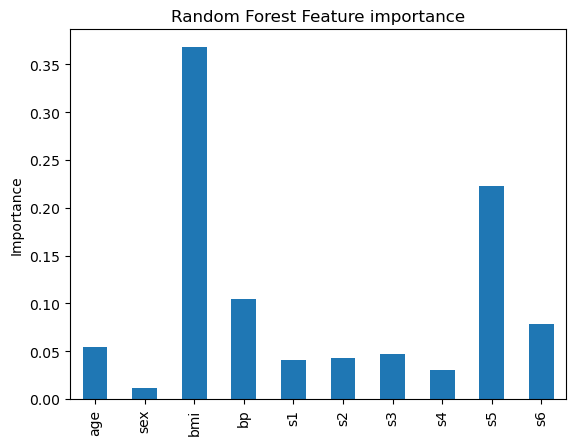

In [24]:
from mlflow.models.signature import infer_signature

with mlflow.start_run(run_name='complete_run') as run:

    print(f"Inside run ID: {run.info.run_id}")

    # Load dataset
    db = load_diabetes(as_frame=True)
    X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

    # Create and train a model
    params = {
        "n_estimators": 100, 
        "max_depth": 20, 
        "max_features": 10
    }

    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)

    # Calculate train and test metrics
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # log model artifact
    signature = infer_signature(X_train, pd.DataFrame(y_train))
    input_example = X_train.head(3)

    mlflow.sklearn.log_model(
        sk_model=rf, 
        artifact_path="random_forest", 
        signature=signature, 
        input_example=input_example
    )

    # log metrics
    metrics = {
        "train_mse": train_mse,
        "test_mse": test_mse,
        "train_r2": train_r2,
        "test_r2": test_r2,
    }

    mlflow.log_metrics(metrics)

    #log parameters
    mlflow.log_params(params)

    #Log a csv file
    df_feature_importance=pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_})
    df_feature_importance.to_csv('feature_importance.csv')

    mlflow.log_artifact('feature_importance.csv')

    # Generate feature importance plot
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    fig, ax = plt.subplots()
    feature_importances.plot.bar(ax=ax)
    ax.set_title("Random Forest Feature importance")
    ax.set_ylabel("Importance")

    # Log figure
    mlflow.log_figure(fig, "feature_importance_rf.png")

Mlflow is awesome, right?

<img src="https://images.squarespace-cdn.com/content/v1/53951756e4b00bb4cdae2705/1438140505820-0NLWP048BD4PQMK3Q8W0/image-asset.png" width="500">


### Autologging
You don't need to log everything **manually**, you can use `mlflow.autolog()` 

If autologging is set before model training, every `.fit()` triggers an experiment log that saves models, parameters and metrics. 

* Classification model? No problem, Mlflow logs classification metrics. 
* Regression model? Again, Mlflow logs regression metrics.

In [25]:
mlflow.autolog()

# Load dataset
db = load_diabetes(as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

# Create and train a model
params = {
    "n_estimators": 100, 
    "max_depth": 20, 
    "max_features": 10
}

rf = RandomForestRegressor(**params)
rf = rf.fit(X_train, y_train)

2024/02/25 23:46:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/25 23:46:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '87091cbeecea43ce987700bbb81be027', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


<img src='https://mlflow.org/docs/latest/_images/autologging-intro.png' width=750>

### Nested runs
<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQEqoUokNZSLGJcIcYxX7ej3B5vQM8OB_dUYRC2hThnILcJ4Zw8p6r4zAxIoxjXFsZw_Xs&usqp=CAU' width=500>

*Yo dawg I heard you like Mlflow runs, so we put an Mlflow run inside your Mlflow run*

In [26]:
with mlflow.start_run(run_name="Nested Example") as run:
    
    with mlflow.start_run(run_name="first child", nested=True):
        mlflow.log_param("run_name", "first")

    with mlflow.start_run(run_name="second child", nested=True):
        mlflow.log_param("run_name", "second")

With nested runs,, you create parent runs and child runs in a tree structure. 

In the MLflow UI, you can click on a parent run to expand it and see the child runs.

This is **very** useful when doing 
- **hyperparameter tuning**, you can nest all associated model runs under a parent run to better organize and compare hyperparameters.
- **iterative training**, such as neural networks, matrix factorization models, you can checkpoint results after n epochs to save the model and related metrics


By using autologging during a hyperparameter tuning process, nested runs are created automatically

In [27]:
from sklearn.model_selection import GridSearchCV

mlflow.sklearn.autolog()

# Load dataset
db = load_diabetes(as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

# Create and train a model
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20],
    "max_features": [10]
}

gs=GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, scoring='r2')
gs.fit(X_train, y_train)

2024/02/25 23:47:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aa3ac5e5f90c4ba0bfad31ac72be9ce1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/25 23:47:17 INFO mlflow.sklearn.utils: Logging the 5 best runs, 4 runs will be omitted.


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 20], 'max_features': [10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [43]:
#replace here your parent run_id
run_id = 'aa3ac5e5f90c4ba0bfad31ac72be9ce1'

In [44]:
mlflow.sklearn.load_model(f'runs:/{run_id}/best_estimator')

RandomForestRegressor(max_depth=5, max_features=10, n_estimators=200)

### Register Model 
Using the UI you can register a model artifact as a Mlflow Model.

For our use case we will register the grid search best estimator as a model called `beautiful_model` and assign it the alias `@champion` in the UI.

You can also promote another experiment as a new version of the model we just created. It is recommender that you also add a relevant description and alias to each registered models that serve as metadata that you can use to identify them.

<img src="img/register_model.png">

In [46]:
mlflow.sklearn.load_model('models:/beautiful_model@champion')

RandomForestRegressor(max_depth=5, max_features=10, n_estimators=200)

Congrats, now you know how to use Mlflow Experiments and Models. **Happy logging**

### Model serving
Now, we will serve our model using a local inference server (check [documentation](https://mlflow.org/docs/latest/deployment/deploy-model-locally.html?highlight=dataframe_split))

`mlflow models serve --model-uri models:/beautiful_model@champion --port 1222`

It will take some time to install the dependencies, but after that you should see some logs that look like this 

```
[2024-02-26 00:06:40 -0500] [5064] [INFO] Starting gunicorn 21.2.0
[2024-02-26 00:06:40 -0500] [5064] [INFO] Listening at: http://127.0.0.1:1222 (5064)
[2024-02-26 00:06:40 -0500] [5064] [INFO] Using worker: sync
[2024-02-26 00:06:40 -0500] [5069] [INFO] Booting worker with pid: 5069
```

If you open postman you can send some POST requests to the path `http://127.0.0.1:1222/invocations`

We make sure to set up 

* headers

<img src="img/post_headers.png">

* body (check that this looks like the input example of the model on the Mlflow UI)

<img src="img/post_body.png">

After the POST we should see an output that looks like this

```
{
    "predictions": [
        163.179877111056
    ]
}
```

So, now you also know how to take an Mlflow model and serve it to an API endpoint on a local server.

Use it for good.